# Wikipedia list of INGO web scraping

Some charities can be considered as "International Non-Governmental Organization" and may not appear directly in the wikipedia "charitable foundation" list. For further information about our datascraping strategy, please refer to "../charities/Wikipeida_harities_scraping.ipynb'. This allows us to complete our dataset with further more possible charities. We scrape this data off the wikipedia page using the beautiful soup library.

In [1]:
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords

### Get the wikipedia list of INGO in html

In [2]:
# Get html webpage
URL = 'https://en.wikipedia.org/wiki/International_non-governmental_organization'
r = requests.get(URL)
page_body = r.text
soup = BeautifulSoup(page_body, 'html.parser')

### Extract name of INGO and link to its wikipedia page from the list

In [3]:
# Find page section containing links
link_sections = soup.findAll('div', class_="mw-parser-output")

In [4]:
# Extracts only wikipedia links
links_lists = [x.findAll('a', attrs={'href': re.compile("/w")}) for x in link_sections]

flat_links_list = [((item.text),(item.get('href'))) for sublist in links_lists for item in sublist]

In [5]:
# Cleaning and flattening of the list
'''
As the wikipedia html page is not well formated, the relevant informations are extracted
with visual aid.
'''
flat_links_list = flat_links_list[44:97]

for tag in flat_links_list[:]:
    if 'edit' in tag:
        flat_links_list.remove(tag)
        
flat_links_list

[('khalsa Aid', '/wiki/Khalsa_Aid'),
 ('ADRA', '/wiki/ADRA'),
 ('CAFOD', '/wiki/CAFOD'),
 ('CARE', '/wiki/CARE_(relief_agency)'),
 ('Oxfam', '/wiki/Oxfam'),
 ('Lakshyam ngo', '/w/index.php?title=Lakshyam_ngo&action=edit&redlink=1'),
 ("SOS Children's Villages", '/wiki/SOS_Children%27s_Villages'),
 ('World Vision International', '/wiki/World_Vision_International'),
 ('Mercy Corps', '/wiki/Mercy_Corps'),
 ('Save the Children', '/wiki/Save_the_Children'),
 ('Good Neighbors International', '/wiki/Good_Neighbors_(NGO)'),
 ('Doctors Without Borders', '/wiki/M%C3%A9decins_Sans_Fronti%C3%A8res'),
 ('HealthRight International', '/wiki/HealthRight_International'),
 ('charity: water', '/wiki/Charity:_water'),
 ('Lakshyam NGO', '/w/index.php?title=Lakshyam_ngo&action=edit&redlink=1'),
 ('Compassion International', '/wiki/Compassion_International'),
 ('Plan', '/wiki/Plan_(aid_organisation)'),
 ('World Association of Girl Guides and Girl Scouts',
  '/wiki/World_Association_of_Girl_Guides_and_Girl_Sc

In [6]:
# Creation of a dataframe containing INGO name and wikipedia link
INGO = pd.DataFrame([(x[0], 'https://en.wikipedia.org' + x[1]) for x in flat_links_list], columns=('name', 'Link'))

In [7]:
# Save scraped link list for further processing
INGO.to_csv('../../generated/INGO/wikipedia_INGO_links.csv')

### Extract information about individual INGO from the table on their linked pages

Now we want to extract information about individual INGOs from the navbox on their linked pages. We use the navbox because it is already semi-structured, making scraping easier. But we need to know what we are looking for, so we collect the available features.

In [8]:
def list_features(INGO):
    '''
    Goes through a list of wikipedia pages and extracts the features shown in the table
    
    input: dataframe including a 'Link' column of wikipedia links as strings
    output: a Series of strings
    '''
    
    features = []
    
    for index, row in INGO.iterrows():
        link = row['Link']
        r_link = requests.get(link)
        soup_link = BeautifulSoup(r_link.text, 'html.parser')
        table = soup_link.find('table', class_="infobox vcard")

        if table is not None:
            table_rows = table.findAll('tr')
            for row in table_rows:
                feature = row.find('th')
                if feature is not None:
                    feature = feature.text
                    features.append(feature)
    return pd.Series(features).unique()


In [9]:
#Get the list of features we can potentially extract about a INGO
list_features(INGO)

array(['Founded', 'Founder', 'Founded at', 'Type', 'Legal status',
       'Focus', 'Headquarters', 'Area served ', 'CEO', 'Revenue  ',
       'Employees  ', 'Volunteers  ', 'Website', 'Location', 'Product',
       'Owner', 'Key people', 'Formation', 'Founders', 'Fields',
       'Secretary General', 'Deputy Secretary General',
       'Chair of the Supervisory Board', 'Named after', 'Director',
       'Abbreviation', 'Purpose', 'President', 'Honorary President',
       'Method', 'Expenses', 'Staff  ', 'Registration\xa0no.', 'Origins',
       'Motto', 'Tax ID no. ',
       'World Association of Girl Guides and Girl Scouts', 'Country',
       'Membership', 'Chair World Board', 'Coordinates',
       'World Organization of the Scout Movement',
       'World Scout Committee Chairman', 'Membership  ', 'Presidents',
       'Praeses', 'Secretary-General', 'Region served ', 'Industry',
       'Services', 'Members  ', 'Official language ',
       'Executive Director', 'Main organ', 'Budget  ', 'Re

Using the features displayed above, we can handcraft lists of more or less synonymous features that will help us create a function capable of handling different type of wikipedia pages.

In [10]:
people_features = ['CEO', 'Secretary General', 'Owner', 'Key people',
                                'Chair', 'Co-executive director', 'President', 'Board Chair',
                                'Chief Executive Officer', 'Board of Directors', 'Executive Director',
                                'National President & CEO', 'Chairman', 'Chief Executive', 
                                'Deputy Secretary General', 'Chair of the Supervisory Board',
                                'Chairman of the Governing Body', 'President/CEO', 'President and CEO',
                                'Board\xa0of directors', 'President of the Board', 'Board of Trustees',
                                'Chair, Adult Advisory Council', 'Leader', 'President, Treasurer', 
                                'President & CEO', 'Executive director', 'Vice president', 'Predecessor',
                                'Chairman of Governors', 'Notable Board Members[1]', 'Board of Directors',
                                'Superior General', 'Honorary President', 'Co-Chairman', 'Managing Director',
                                'Chair World Board', 'President Emeritus', 'Director General',
                                'Founder', 'Founders']

money_features = ['Revenue', 'Revenue  ',
                                'Revenue .mw-parser-output .nobold{font-weight:normal}(2016) ',
                                'Revenue .mw-parser-output .nobold{font-weight:normal}(2015) ', 
                                'Revenue .mw-parser-output .nobold{font-weight:normal}(2014) ',
                                'Revenue .mw-parser-output .nobold{font-weight:normal}(2017) ',
                                'Revenue .mw-parser-output .nobold{font-weight:normal}(2016) ',
                                'Net income', 'Total assets', 'Operating income',
                                'Revenue (FY 2015)' ]

hq_features = ['Headquarters', 'Address']

country_features = ['Location', 'Chapters', 'Region ', 'Country']

old_name_features = ['Formerly called', 'Abbreviation', 'Parent organization']

affiliation_features = ['Subsidiaries', 'Affiliation']

purpose_features = ['Purpose', 'Focus', 'Product', 'Services', 'Industry', 'Fields']

Now we can get down to work and extract actual information from the links.

In [11]:
#Helper functions to extract information from a wikipedia page about a INGO

#using the list above, go through the INGO wikipedia pages and attempt to draw out any possible information
def extract_info_from_table(table):
    '''
    Extracts information from a given html table
    
    Input: an html table containing information about a charity
    Output: list of string of the following shape about a charity (if present):
        [leader1, leader2, leader3, leader4, revenue, hq, location, other_names, subsidiaries, purpose]
    '''
    
    #placeholders for the information we want
    leader1 = None
    leader2 = None
    leader3 = None
    leader4 = None
    leader1_set = False
    leader2_set = False
    leader3_set = False
    leader4_set = False
    
    revenue = None
    hq = None
    location = None
    other_names = None
    subsidiaries = None
    purpose = None
        
    if table is not None:
        #for each table row
        table_rows = table.findAll('tr')
        for row in table_rows:
            #find the feature and its value
            feature = row.find('th')
            value = row.find('td')
            if feature is not None and value is not None:
                #cast them to strings
                feature = feature.text
                value = value.text
                
                #check which category the feature belongs to and insert the value in a placeholder
                if feature in people_features:
                    if leader1_set == False:
                        leader1 = value
                        leader1_set = True
                    elif leader2_set == False:
                        leader2 = value
                        leader2_set = True
                    elif leader3_set == False:
                        leader3 = value
                        leader3_set = True
                    elif leader4_set == False:
                        leader4 = value
                        leader4_set = True
                elif feature in money_features:
                    revenue = value
                elif feature in hq_features:
                    hq = value
                elif feature in country_features:
                    location = value
                elif feature in old_name_features:
                    other_names = value
                elif feature in affiliation_features:
                    subsidiaries = value
                elif feature in purpose_features:
                    purpose = value
                    
    #return the information
    return [leader1, leader2, leader3, leader4, revenue, hq, location, other_names, subsidiaries, purpose]
    
        

def extract_info_from_link(link):
    '''
    Given a wikipedia link, find its navbox and extract information
    
    Input: wikipedia link
    Output: list of string of the following shape about a charity (if present):
            [leader1, leader2, leader3, leader4, revenue, hq, location, other_names, subsidiaries, purpose]
    
    '''
    r_link = requests.get(link)
    soup_link = BeautifulSoup(r_link.text, 'html.parser')
    table = soup_link.find('table', class_="infobox vcard")
    return extract_info_from_table(table)

Using these helper functions, we iterate through the links and check each one for information.

In [12]:
# Extraction of INGO information
detailed_INGO = []
for index, row in INGO.iterrows():
    name = row['name']
    link = row['Link']
    INGO_details = extract_info_from_link(link)
    INGO_details.insert(0, name)
    detailed_INGO.append(INGO_details)

In [13]:
# Cleaned and renamed dataframe categories
INGO_detailed = pd.DataFrame(detailed_INGO,
                                  columns=['name', 'Leader 1', 'Leader 2', 'Leader 3', 'Leader 4',
                                           'Revenue', 'Headquarters', 'Location', 'Other names', 'Subsidiaries',
                                          'Purpose'])

INGO_detailed.head(5)

,name,Leader 1,Leader 2,Leader 3,Leader 4,Revenue,Headquarters,Location,Other names,Subsidiaries,Purpose
0,khalsa Aid,Ravi Singh,Ravi Singh,None,None,£1M,"Slough, England",None,None,None,Provides humanitarian aid in disaster areas an...
1,ADRA,Seventh-day Adventist Church,Seventh-day Adventist Church,"Jonathan Duffy, President; Korey Dowling, Vice...",None,"$173,000,000 (2009)",None,"Silver Spring, Maryland, USA",None,None,Provides individual and community development ...
2,CAFOD,None,None,None,None,None,None,None,None,None,None
3,CARE,"Arthur C. Ringland, Wallace J. Campbell, Linco...",Caroline Kende-Robb,Lindsay Glassco,Madame Louise Fréchette,None,None,None,None,None,Humanitarian relief and development support
4,Oxfam,None,None,None,None,None,"Oxfam International, Oxfam House, John Smith D...",None,None,None,Poverty eradicationdisaster relief advocacy po...


In [14]:
INGO_detailed.describe()

,name,Leader 1,Leader 2,Leader 3,Leader 4,Revenue,Headquarters,Location,Other names,Subsidiaries,Purpose
count,45,29,14,6,2,12,14,23,8,0.0,24
unique,42,27,12,5,2,11,12,22,6,0.0,20
top,SOS Children's Villages,Hermann Gmeiner,Siddharta Kaul,Helmut Kutin,Madame Louise Fréchette,US$1.01 billion (2016)[4],"Antwerpen, Belgium","Monrovia, California, U.S., 800 West Chestnut ...",SOS,NaN,International umbrella organization of catholi...
freq,2,2,2,2,1,2,2,2,2,NaN,2


We see that this is still relatively messy, with lots of information missing, and sometimes misstored columns or mulitple values in each field. This is okay, though, because the names are neat and they will be our primary point of comparison with the panama papers. Once we have narrowed down the charities based on the names, if we need more information about the (hopefully) small subset of charities, we can do more cleaning then. 

Meanwhile, let's save this information and analyse it a bit more carefully.

In [15]:
#Save the data as a csv file
INGO_detailed.to_csv('../../generated/INGO/INGO_charity_info.csv')

In [16]:
#reload the data to make sure it's okay
df = pd.read_csv('../../generated/INGO/INGO_charity_info.csv', index_col=0)
df.head(5)

,name,Leader 1,Leader 2,Leader 3,Leader 4,Revenue,Headquarters,Location,Other names,Subsidiaries,Purpose
0,khalsa Aid,Ravi Singh,Ravi Singh,NaN,NaN,£1M,"Slough, England",NaN,NaN,NaN,Provides humanitarian aid in disaster areas an...
1,ADRA,Seventh-day Adventist Church,Seventh-day Adventist Church,"Jonathan Duffy, President; Korey Dowling, Vice...",NaN,"$173,000,000 (2009)",NaN,"Silver Spring, Maryland, USA",NaN,NaN,Provides individual and community development ...
2,CAFOD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CARE,"Arthur C. Ringland, Wallace J. Campbell, Linco...",Caroline Kende-Robb,Lindsay Glassco,Madame Louise Fréchette,NaN,NaN,NaN,NaN,NaN,Humanitarian relief and development support
4,Oxfam,NaN,NaN,NaN,NaN,NaN,"Oxfam International, Oxfam House, John Smith D...",NaN,NaN,NaN,Poverty eradicationdisaster relief advocacy po...


Looks like it survived the csv. Time to analyse!

We start with the names, since they are the most important part of the charity for our research (primary point of comparison with the panama papers).

To figure out how often we might accidentally come across matches based on rather generic names, we analyse the words that make up the names.

### Analysis of extracted INGO info

In [17]:
names = df['name']

#Separate the words in the names
split_names = names.str.split()
words_in_names = pd.DataFrame([word for name in split_names for word in name], columns=['Words'])

#Count how often specific words appear
words_in_names['Count'] = 1
word_frequency = words_in_names.groupby('Words').count().reset_index()\
                    .sort_values(by='Count', ascending=False)\
                    .reset_index(drop=True)
word_frequency.head(5)

,Words,Count
0,International,15
1,of,8
2,World,6
3,for,3
4,the,3


We see that we have a lot of "stop words" (words that exist mostly for grammatical purposes, like "of" and "for"). Since these aren't very interesting (because they are everywhere!) we can remove them using nltk's predefined list of English stop words.

In [18]:
stop_words = set(stopwords.words('english'))
big_words = word_frequency[word_frequency['Words'].str.lower().isin(stop_words) == False]\
                    .sort_values(by='Count', ascending=False)\
                    .reset_index(drop=True)
big_words.head(5)

,Words,Count
0,International,15
1,World,6
2,Youth,3
3,Nature,3
4,Federation,3


In [19]:
big_words.plot(title='Distribution of the number of times a word appears in INGO names')

In [20]:
big_words.describe()

,Count
count,85.000000
mean,1.482353
std,1.659115
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,15.000000


Of our approximate 85 words, we seem to have quite a few  that are used multiple times. Let's find out what they are.

In [21]:
common_words = big_words[big_words['Count'] > 2]
common_words.describe()

,Count
count,6.000000
mean,5.500000
std,4.806246
min,3.000000
25%,3.000000
50%,3.000000
75%,5.250000
max,15.000000


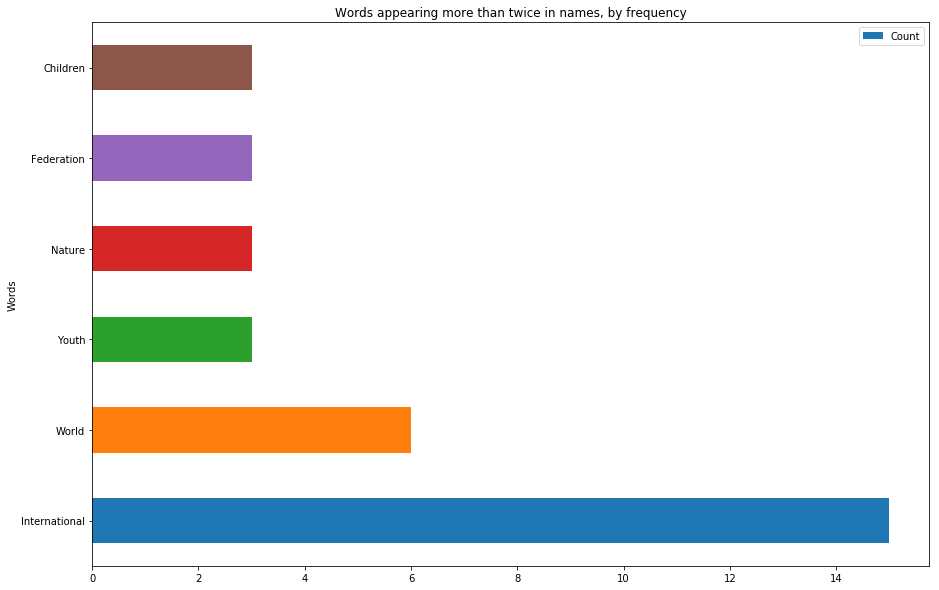

In [22]:
common_words.plot(kind='barh', x='Words', y='Count', figsize=(15, 10),
                  title='Words appearing more than twice in names, by frequency')

We can see that while there are a few "generic" words (International, World, Federation) that are not suprising for INGOs, some of the them are rather specialized (Youth, Nature, Children). These are the ones that should help us track down charities in the panama papers or other leaked data.